In [1]:
#Load libraries
import os
import numpy as np
import torch
import glob
import torch.nn as nn
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
import torch.optim as optim 
from torch.autograd import Variable
import pathlib


In [2]:
import torchvision

In [3]:
#!pip install torchsummary

In [4]:
from torchsummary import summary

In [5]:
#checking for device
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
print(device)

cpu


In [7]:
transformer=transforms.Compose([
    transforms.Resize((150,150)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),  #0-255 to 0-1, numpy to tensors
    transforms.Normalize([0.5,0.5,0.5], # 0-1 to [-1,1] , formula (x-mean)/std
                        [0.5,0.5,0.5])
])

In [8]:
train_path = 'E:/Term 2/DL with PyTorch/Project/archive/seg_train'
test_path = 'E:/Term 2/DL with PyTorch/Project/archive/seg_test'


train_loader=DataLoader(
    torchvision.datasets.ImageFolder(train_path,transform=transformer),
    batch_size=128, shuffle=True
)

test_loader=DataLoader(
    torchvision.datasets.ImageFolder(test_path,transform=transformer),
    batch_size=32, shuffle=True
)

In [9]:
root=pathlib.Path(train_path)
classes=sorted([j.name.split('/')[-1] for j in root.iterdir()])

In [10]:
print(classes)

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


In [13]:
class ConvNet(nn.Module):
    def __init__(self,num_classes=6):
        super(ConvNet,self).__init__()
        
        #Output size after convolution filter
        #((w-f+2P)/s) +1
        
        #Input shape= (256,3,150,150)
        
        self.conv1=nn.Conv2d(in_channels=3,out_channels=12,kernel_size=3,stride=1,padding=1)
        #Shape= (256,12,150,150)
        self.bn1=nn.BatchNorm2d(num_features=12)
        #Shape= (256,12,150,150)
        self.relu1=nn.ReLU()
        #Shape= (256,12,150,150)
        
        self.pool=nn.MaxPool2d(kernel_size=2)
        #Reduce the image size be factor 2
        #Shape= (256,12,75,75)
        
        
        self.conv2=nn.Conv2d(in_channels=12,out_channels=20,kernel_size=3,stride=1,padding=1)
        #Shape= (256,20,75,75)
        self.relu2=nn.ReLU()
        #Shape= (256,20,75,75)
        
        
        
        self.conv3=nn.Conv2d(in_channels=20,out_channels=32,kernel_size=3,stride=1,padding=1)
        #Shape= (256,32,75,75)
        self.bn3=nn.BatchNorm2d(num_features=32)
        #Shape= (256,32,75,75)
        self.relu3=nn.ReLU()
        #Shape= (256,32,75,75)

        self.fc=nn.Linear(in_features=75 * 75 * 32,out_features=num_classes)
        
        self.dropout = nn.Dropout(p=0.5)
        
        #Feed forwad function
        
    def forward(self,input):
        output=self.conv1(input)
        output=self.bn1(output)
        output=self.relu1(output)
            
        output=self.pool(output)
        output=self.dropout(output)
        
        output=self.conv2(output)
        output=self.relu2(output)
            
        output=self.conv3(output)
        output=self.bn3(output)
        output=self.relu3(output)
            
            
        #Above output will be in matrix form, with shape (256,32,75,75)
            
        output=output.view(-1,32*75*75)
            
            
        output=self.fc(output)
            
        return output
            

In [14]:
model=ConvNet(num_classes=6).to(device)

In [15]:
summary(model,(3,150,150))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 12, 150, 150]             336
       BatchNorm2d-2         [-1, 12, 150, 150]              24
              ReLU-3         [-1, 12, 150, 150]               0
         MaxPool2d-4           [-1, 12, 75, 75]               0
           Dropout-5           [-1, 12, 75, 75]               0
            Conv2d-6           [-1, 20, 75, 75]           2,180
              ReLU-7           [-1, 20, 75, 75]               0
            Conv2d-8           [-1, 32, 75, 75]           5,792
       BatchNorm2d-9           [-1, 32, 75, 75]              64
             ReLU-10           [-1, 32, 75, 75]               0
           Linear-11                    [-1, 6]       1,080,006
Total params: 1,088,402
Trainable params: 1,088,402
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.26
Forw

In [16]:
#Optmizer and loss function
optimizer=optim.SGD(model.parameters(),lr=0.001)
loss_function=nn.CrossEntropyLoss()

In [17]:
num_epochs=5

In [18]:
#calculating the size of training and testing images
train_count=len(glob.glob(train_path+'/**/*.jpg'))
test_count=len(glob.glob(test_path+'/**/*.jpg'))

In [19]:

print(train_count,test_count)

14034 3000


In [20]:
#!pip install matplotlib --user

In [21]:
#pip install --upgrade pip

In [22]:
import matplotlib.pyplot as plt

# Initialize lists to store losses
train_loss_list = []
test_loss_list = []
train_accuracy_list =[]
test_accuracy_list =[]

best_accuracy = 0.0

for epoch in range(num_epochs):
    # Evaluation and training on the training dataset
    model.train()
    train_accuracy = 0.0
    train_loss = 0.0
    test_loss = 0.0

    for i, (images, labels) in enumerate(train_loader):
        if torch.cuda.is_available():
            images = Variable(images.cuda())
            labels = Variable(labels.cuda())

        optimizer.zero_grad()

        outputs = model(images)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.cpu().detach().numpy() * images.size(0)
        _, prediction = torch.max(outputs.data, 1)

        train_accuracy += int(torch.sum(prediction == labels.data))

    train_accuracy = train_accuracy / train_count
    train_loss = train_loss / train_count
    train_loss_list.append(train_loss)
    train_accuracy_list.append(train_accuracy)

    # Evaluation on the testing dataset
    model.eval()
    test_accuracy = 0.0

    for i, (images, labels) in enumerate(test_loader):
        if torch.cuda.is_available():
            images = Variable(images.cuda())
            labels = Variable(labels.cuda())
            
        outputs = model(images)
        loss = loss_function(outputs, labels)
        _, prediction = torch.max(outputs.data, 1)
        test_accuracy += int(torch.sum(prediction == labels.data))
        test_loss += loss.cpu().detach().numpy() * images.size(0)
    test_accuracy = test_accuracy / test_count
    test_accuracy_list.append(test_accuracy)
    test_loss = test_loss / test_count
    test_loss_list.append(test_loss)
    

    print(
        "Epoch: "
        + str(epoch)
        + " Train Loss: "
        + str(train_loss)
        + " Test Loss: "
        + str(test_loss)
        + " Train Accuracy: "
        + str(train_accuracy)
        + " Test Accuracy: "
        + str(test_accuracy)
    )

    # Save the best model
    if test_accuracy > best_accuracy:
        torch.save(model.state_dict(), "best_checkpoint.model")
        best_accuracy = test_accuracy

Epoch: 0 Train Loss: 2.5375183957483043 Test Loss: 1.7723418407440186 Train Accuracy: 0.42696308963944707 Test Accuracy: 0.444
Epoch: 1 Train Loss: 1.6891144574563421 Test Loss: 1.2348862903912863 Train Accuracy: 0.5256519880290722 Test Accuracy: 0.5706666666666667
Epoch: 2 Train Loss: 1.3793511103068354 Test Loss: 1.3251921491622924 Train Accuracy: 0.5701866894684338 Test Accuracy: 0.5926666666666667
Epoch: 3 Train Loss: 1.220250344504076 Test Loss: 1.3984960916837057 Train Accuracy: 0.5986176428673222 Test Accuracy: 0.5886666666666667
Epoch: 4 Train Loss: 1.1120755720532687 Test Loss: 1.5923790130615234 Train Accuracy: 0.6197092774690038 Test Accuracy: 0.5206666666666667


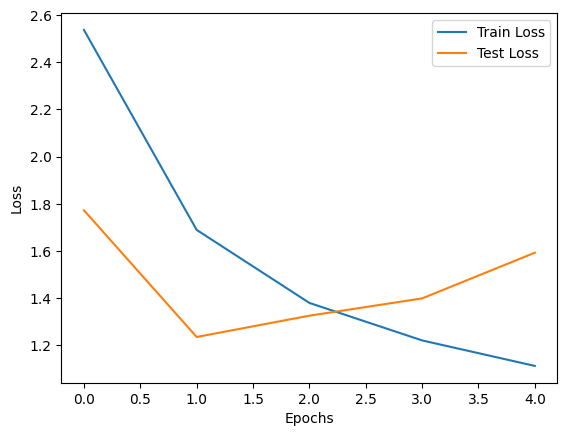

In [23]:
plt.plot(train_loss_list, label="Train Loss")
plt.plot(test_loss_list, label="Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

I have to plot the training loss by saving after every epoch, then we will have 5 values for 5 epochs, 10 values for 10 epochs.
As I am doing at the end, I am getting the last loss value here.

In [24]:
epochs = range(num_epochs)
epochs

range(0, 5)

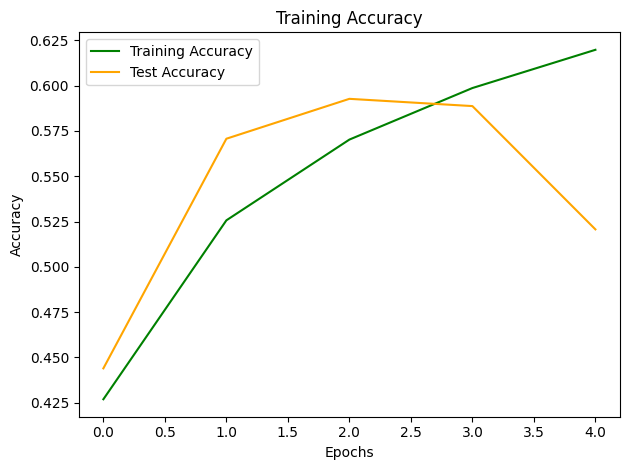

In [25]:
# Plotting Training Accuracy
plt.subplot(1, 1, 1)
plt.plot(epochs,train_accuracy_list, label='Training Accuracy', color='green')
plt.plot(epochs,test_accuracy_list, label='Test Accuracy', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [26]:
#pip install cv2

In [27]:
from torchvision.models import squeezenet1_1
import torch.functional as F
from io import open
from PIL import Image

In [28]:
pred_path = 'E:/Term 2/DL with PyTorch/Project/archive/seg_pred/seg_pred'

In [29]:
checkpoint=torch.load('best_checkpoint.model')
model=ConvNet(num_classes=6)
model.load_state_dict(checkpoint)
model.eval()

ConvNet(
  (conv1): Conv2d(3, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(12, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (conv3): Conv2d(20, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (fc): Linear(in_features=180000, out_features=6, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [30]:
#Transforms
transformer=transforms.Compose([
    transforms.Resize((150,150)),
    transforms.ToTensor(),  #0-255 to 0-1, numpy to tensors
    transforms.Normalize([0.5,0.5,0.5], # 0-1 to [-1,1] , formula (x-mean)/std
                        [0.5,0.5,0.5])
])

In [31]:
#prediction function
def prediction(img_path,transformer):
    
    image=Image.open(img_path)
    
    image_tensor=transformer(image).float()
    
    
    image_tensor=image_tensor.unsqueeze_(0)
    
    if torch.cuda.is_available():
        image_tensor.cuda()
        
    input=Variable(image_tensor)
    
    
    output=model(input)
    
    index=output.data.numpy().argmax()
    
    pred=classes[index]
    
    return pred

In [32]:
images_path=glob.glob(pred_path+'/*.jpg') #'/**/*.jpg'

In [33]:
pred_dict={}

In [34]:
for i in images_path:
    pred_dict[i[i.rfind('/')+1:]]=prediction(i,transformer)

In [35]:
count = 0
for key, value in pred_dict.items():
    if count < 30:
        print(key, value)
        count += 1

seg_pred\10004.jpg forest
seg_pred\10005.jpg mountain
seg_pred\10012.jpg street
seg_pred\10013.jpg mountain
seg_pred\10017.jpg glacier
seg_pred\10021.jpg forest
seg_pred\1003.jpg mountain
seg_pred\10034.jpg glacier
seg_pred\10038.jpg mountain
seg_pred\10040.jpg street
seg_pred\10043.jpg mountain
seg_pred\10045.jpg buildings
seg_pred\10047.jpg sea
seg_pred\10048.jpg buildings
seg_pred\10052.jpg buildings
seg_pred\10054.jpg glacier
seg_pred\10059.jpg forest
seg_pred\10060.jpg forest
seg_pred\10066.jpg mountain
seg_pred\10069.jpg glacier
seg_pred\10073.jpg forest
seg_pred\10079.jpg street
seg_pred\1008.jpg street
seg_pred\10082.jpg forest
seg_pred\10083.jpg buildings
seg_pred\10090.jpg buildings
seg_pred\10092.jpg forest
seg_pred\10096.jpg mountain
seg_pred\101.jpg glacier
seg_pred\10100.jpg mountain


In [36]:
print(images_path[:10],'\n')

['E:/Term 2/DL with PyTorch/Project/archive/seg_pred/seg_pred\\10004.jpg', 'E:/Term 2/DL with PyTorch/Project/archive/seg_pred/seg_pred\\10005.jpg', 'E:/Term 2/DL with PyTorch/Project/archive/seg_pred/seg_pred\\10012.jpg', 'E:/Term 2/DL with PyTorch/Project/archive/seg_pred/seg_pred\\10013.jpg', 'E:/Term 2/DL with PyTorch/Project/archive/seg_pred/seg_pred\\10017.jpg', 'E:/Term 2/DL with PyTorch/Project/archive/seg_pred/seg_pred\\10021.jpg', 'E:/Term 2/DL with PyTorch/Project/archive/seg_pred/seg_pred\\1003.jpg', 'E:/Term 2/DL with PyTorch/Project/archive/seg_pred/seg_pred\\10034.jpg', 'E:/Term 2/DL with PyTorch/Project/archive/seg_pred/seg_pred\\10038.jpg', 'E:/Term 2/DL with PyTorch/Project/archive/seg_pred/seg_pred\\10040.jpg'] 



In [37]:
#pip install --upgrade pip --user

In [38]:
#pip install scikit-learn==0.24.2

In [39]:
#pip install scikit-learn

In [40]:
# Metrics Calculation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns

Accuracy: 0.596
Precision: 0.6831656089371344
Recall: 0.5906838518037707
F1 Score: 0.5438685611214796


C:\Users\Pavilions\AppData\Local\Temp\ipykernel_15868\2583156638.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics, y=scores, palette='viridis')


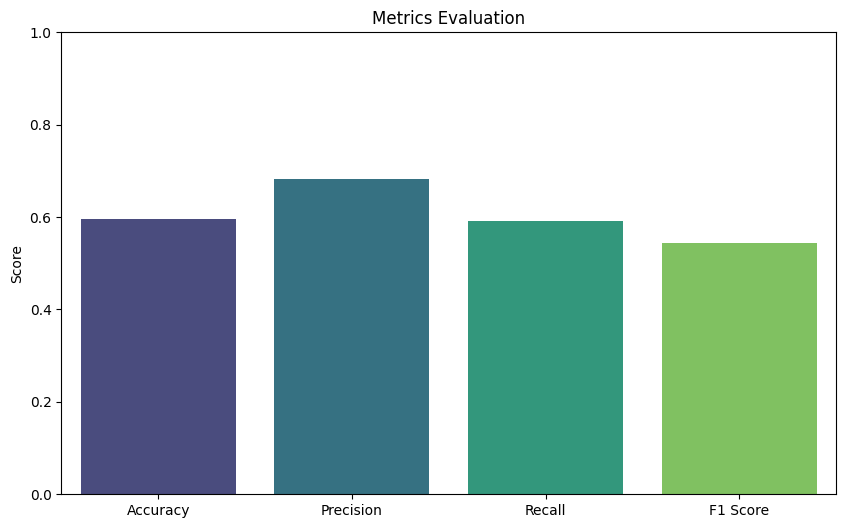

Metrics Report:
------------------------
Accuracy: 0.5960
Precision: 0.6832
Recall: 0.5907
F1 Score: 0.5439


In [41]:

# Flatten predictions and labels for metrics calculation
val_predictions = []
val_labels = []

for images, labels in test_loader:
    if torch.cuda.is_available():
        images = Variable(images.cuda())
        labels = labels.cuda()

    outputs = model(images)
    _, prediction = torch.max(outputs.data, 1)

    val_predictions.extend(prediction.cpu().numpy())
    val_labels.extend(labels.cpu().numpy())

# Calculate Metrics
accuracy = accuracy_score(val_labels, val_predictions)
precision = precision_score(val_labels, val_predictions, average='macro')
recall = recall_score(val_labels, val_predictions, average='macro')
f1 = f1_score(val_labels, val_predictions, average='macro')

print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)

metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
scores = [accuracy, precision, recall, f1]

# Plotting the scores
plt.figure(figsize=(10, 6))
sns.barplot(x=metrics, y=scores, palette='viridis')
plt.title('Metrics Evaluation')
plt.ylabel('Score')
plt.ylim(0, 1)  # Limit the y-axis from 0 to 1 for better visualization
plt.show()

# Creating a report
print('Metrics Report:')
print('------------------------')
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


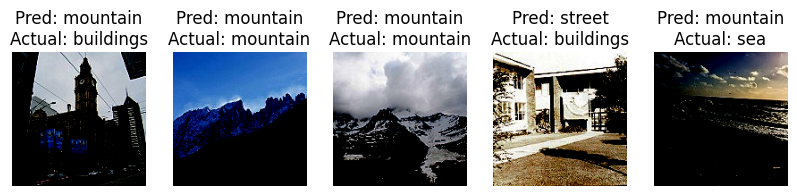

In [42]:
def visualize_predictions(model, dataloader, num_images=5):
    model.eval()
    images_so_far = 0
    fig, ax = plt.subplots(1, num_images, figsize=(10, 5))

    with torch.no_grad():
        for images, labels in dataloader:
            if torch.cuda.is_available():
                images = images.cuda()
                labels = labels.cuda()

            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            for j in range(images.size()[0]):
                images_so_far += 1
                ax[j].imshow(images.cpu().data[j].permute(1, 2, 0))
                ax[j].axis('off')
                ax[j].set_title(f'Pred: {classes[preds[j]]}\nActual: {classes[labels[j]]}')

                if images_so_far == num_images:
                    return

# Visualize predictions on validation set
visualize_predictions(model, test_loader, num_images=5)
plt.show()

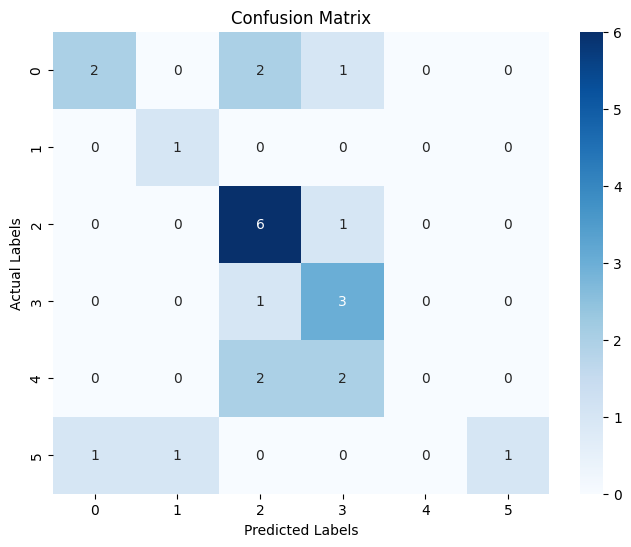

In [43]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Initialize lists to store actual and predicted labels
actual_labels = []
predicted_labels = []

# Inside your testing loop, after making predictions, add the following lines:
actual_labels.extend(labels.data.numpy())
predicted_labels.extend(prediction.data.numpy())

# Calculate confusion matrix
conf_matrix = confusion_matrix(actual_labels, predicted_labels)

# Plot confusion matrix using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.title('Confusion Matrix')
plt.show()